In [53]:
r"""
Optimizing noisy circuits in Cirq
=================================

.. meta::
    :property="og:description": Learn how to optimize and train noisy quantum computations.
    :property="og:image": https://pennylane.ai/qml/_images/noisy_circuit_optimization_thumbnail.png

How does noise influence quantum computing and quantum machine 
learning algorithms? Until we have fault-tolerant quantum computers, 
we will have to learn to live with noise. There are lots of exciting 
ideas and algorithms in the quantum computing space, but how well do 
they survive the reality of today's noisy devices? 

Background
----------

Quantum pure-state simulators are great and readily available in 
a number of quantum software packages. 
They allow us to experiment, prototype, test, and validate algorithms
and research ideas---up to a certain number of qubits, at least 😉.

But present-day hardware is not ideal. We're forced to confront 
decoherence, bit flips, amplitude damping, and so on. Does the 
presence of noise in near-term devices impact their use in, 
for example, 
:doc:`variational quantum algorithms </glossary/variational_circuit>_`?
Won't our models, trained so carefully in simulators, fall apart 
when we run on noisy devices?

In fact, there is some optimism that variational algorithms may be
the best type of algorithms on near-term devices, and may in fact
have an in-built tolerance of noise that "textbook" algorithms 
would not. 

In some ways, variational algorithms are robust against the fact 
that the device they are run on may not be ideal. Being variational
in nature, they can be tuned to "work around" noise to some extent. 

Quantum machine learning leverages a lot of tools from its 
classical counterpart. Fortunately, there is lots of evidence that
machine learning algorithms can not only be robust to noise, but 
can even benefit from it! Examples include the use of 
`reduced-precision arithmetic in deep learning <https://dl.acm.org/doi/abs/10.5555/3045118.3045303>_`,
the strong performance of
`stochastic gradient descent <https://en.wikipedia.org/wiki/Stochastic_gradient_descent>`_ 
and the use of "dropout" noise to 
`prevent overfitting <https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf>`_. 

So we undertake to find, extract, and work with the quantum "signal" 
that is influenced by a device's inhernet noise. 


Noisy circuits
--------------

Let's consider a simple quantum circuit which performs a standard
"textbook" quantum information task: the creation of an entangled
state and the measurement of a 
`Bell inequality <https://en.wikipedia.org/wiki/Bell%27s_theorem>`_
(also known as the 
`CHSH inequality <https://en.wikipedia.org/wiki/CHSH_inequality>`_).

We'll use the mixed-state device provided by 
`Cirq <https://cirq.readthedocs.io>`_ to carry out our noisy 
simulations.
"""

'\nOptimizing noisy circuits in Cirq\n=================================\n\n.. meta::\n    :property="og:description": Learn how to optimize and train noisy quantum computations.\n    :property="og:image": https://pennylane.ai/qml/_images/noisy_circuit_optimization_thumbnail.png\n\nHow does noise influence quantum computing and quantum machine \nlearning algorithms? Until we have fault-tolerant quantum computers, \nwe will have to learn to live with noise. There are lots of exciting \nideas and algorithms in the quantum computing space, but how well do \nthey survive the reality of today\'s noisy devices? \n\nBackground\n----------\n\nQuantum pure-state simulators are great and readily available in \na number of quantum software packages. \nThey allow us to experiment, prototype, test, and validate algorithms\nand research ideas---up to a certain number of qubits, at least 😉.\n\nBut present-day hardware is not ideal. We\'re forced to confront \ndecoherence, bit flips, amplitude damping,

In [43]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

dev = qml.device("cirq.mixedsimulator", wires=2)

In [44]:
# CHSH observables
A1 = qml.PauliZ(0)
A2 = qml.PauliX(0)
B1 = qml.Hermitian(np.array([[1, 1], [1, -1]]) / np.sqrt(2), wires=1)
B2 = qml.Hermitian(np.array([[1, -1], [-1, -1]]) / np.sqrt(2), wires=1)
CHSH_observables = [A1 @ B1, A1 @ B2, A2 @ B1, A2 @ B2]

# subcircuit for creating an entangled pair of qubits
def bell_pair():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])

# circuits for measuring each observable
@qml.qnode(dev)
def measure_A1B1():
    bell_pair()
    return qml.expval(A1 @ B1)

@qml.qnode(dev)
def measure_A1B2():
    bell_pair()
    return qml.expval(A1 @ B2)

@qml.qnode(dev)
def measure_A2B1():
    bell_pair()
    return qml.expval(A2 @ B1)

@qml.qnode(dev)
def measure_A2B2():
    bell_pair()
    return qml.expval(A2 @ B2)

circuits = qml.QNodeCollection([measure_A1B1, 
                                measure_A1B2, 
                                measure_A2B1, 
                                measure_A2B2])

In [51]:
# now we measure each circuit and construct the Bell inequality
expvals = circuits()

CHSH_expval = np.sum(expvals[:3]) - expvals[3]
print(CHSH_expval)

2.828426718711853


In [4]:
##############################################################################
# The output here is the maximal value of the CHSH inequality, which
# is :math:`2\sqrt{2}`. States which have a value 
# :math:`\langle CHSH \geq \leq 2` can safely be considered
# "quantum". 
#
# Now let's turn up the noise! 📢 📢 📢
#
# Cirq provides a number of noisy channels that are not part of
# PennyLane core. This is no problem, as the 
# `PennyLane-Cirq <https://pennylane-cirq.readthedocs.io>`_ 
# plugin provides these and allows them to be used in PennyLane 
# circuit declartions.

In [5]:
from pennylane_cirq import ops as cirq_ops
import inspect
inspect.getmembers(cirq_ops, inspect.isclass)

[('AmplitudeDamp', pennylane_cirq.ops.AmplitudeDamp),
 ('BitFlip', pennylane_cirq.ops.BitFlip),
 ('Depolarize', pennylane_cirq.ops.Depolarize),
 ('Operation', pennylane.operation.Operation),
 ('PhaseDamp', pennylane_cirq.ops.PhaseDamp),
 ('PhaseFlip', pennylane_cirq.ops.PhaseFlip)]

In [103]:
##############################################################################
# PennyLane operations and framework-specific operations can be 
# interwoven freely in circuits that use that plugin's device
# for execution.
# In this case, the Cirq-provided channels can be used with 
# Cirq's mixed state simulator.
#
# We'll use the ``BitFlip`` channel, which has the effect of
# randomly flipping the qubits in the computational basis.

noise_vals = np.linspace(0, 1, 25)

CHSH_vals = []
noisy_expvals = []

for p in noise_vals:
    # we overwrite the ``bell_pair`` subcircuit to add 
    # extra noisy channels after the entangled state is created 
    def bell_pair():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        cirq_ops.BitFlip(p, wires=0)
        cirq_ops.BitFlip(p, wires=1)
    # measuring the circuits will now use the new noisy bell_pair function    
    expvals = circuits()
    noisy_expvals.append(expvals)
noisy_expvals = np.array(noisy_expvals)
CHSH_expvals = np.sum(noisy_expvals[:,:3], axis=1) - noisy_expvals[:,3]

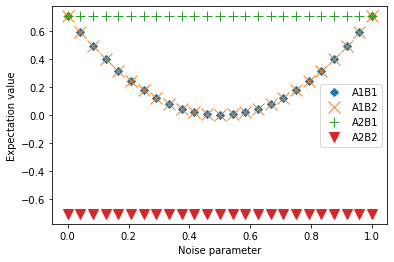

In [111]:
# Plot the individual observables
plt.plot(noise_vals, noisy_expvals[:, 0], 'D', label = "A1B1", markersize=5)
plt.plot(noise_vals, noisy_expvals[:, 1], 'x', label = "A1B2", markersize=12)
plt.plot(noise_vals, noisy_expvals[:, 2], '+', label = "A2B1", markersize=10)
plt.plot(noise_vals, noisy_expvals[:, 3], 'v', label = "A2B2", markersize=10)
plt.xlabel('Noise parameter')
plt.ylabel('Expectation value')
plt.legend()
plt.show()

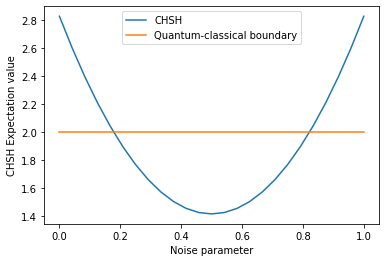

In [115]:
##############################################################################
# By adding the bit-flip noise, we've degraded the value of the 
# CHSH observable. The first two observables :math:`A_1\otimes B_1` 
# and :math:`A_1\otimes B_2` are sensitive to this noise parameter. 
# Their value is weakened when the noise parameter is not 
# 0 or 1 (note that the the CHSH inequality is symmetric with 
# respect to bit-flips).
#
# The latter two observables, on the other hand, are seemingly 
# unaffected by the noise at all.
#
# Even when noise is present, there may still be subspaces 
# or observables which are minimally affected or unaffected. 
# This gives us some hope that variational algorithms can learn
# to find and exploit such noise-free substructures on otherwise
# noisy devices.
#
# We can also plot the CHSH observable in the noisy case. Remember,
# values greater than 2 can safely be considered "quantum".

plt.plot(noise_vals, CHSH_expvals, label="CHSH")
plt.plot(noise_vals, 2 * np.ones_like(noise_vals), label="Quantum-classical boundary")
plt.xlabel('Noise parameter')
plt.ylabel('CHSH Expectation value')
plt.legend()
plt.show()

In [ ]:
##############################################################################
# Too much noise (around 0.2 in this example), and we lose the 
# quantumness we created in our circuit. But if we only have a little
# noise, the quantumness undeniably remains. So there is still hope
# that quantum algorithms can do something useful, even on noisy 
# near-term devices.
#
# ..note::
#
#   In Google's quantum supremacy paper [#arute2019]_, 
#   they were able to show that some 
#   small signature of quantumness remained in their computations, 
#   even after a deep many-qubit circuit was executed.

Still to do:

- Connections of parameter-shift rule with noisy circuits:
    - if your circuit is subject to noisy channels, but the gates themselves are not noisy, completely justified to use parameter-shift rule on gates (i.e., you are getting the correct gradients of the circuit that is taking place)
    - do have to be careful though that the state/observable that you obtain with a noisy channel is not the same one you might want (e.g., VQE, ground state can never be mixed)
    - Interestingly, variants of the parameter-shift rule also hold for a number of "parameterized" channels
    - these parameters themselves might not be easily controllable, but this could still be useful for some quantum information tasks
- Usage demos
    - qubit rotation with mixed state
    - show how mixed state can achieve same expval as pure state
    - show how noisy state cannot reach some expvals that pure state can
    - show how parameter-shift rule can work for channels in practice

- emphasize that channels don't always act "in-between" gates, but it's a suitable model


In [4]:
@qml.qnode(mdev)
def circuit(gate_params, noise_param=0.0):
    qml.RX(gate_params[0], wires=0)
    qml.RY(gate_params[1], wires=0)
    cirq_ops.Depolarize(noise_param, wires=0)
    return qml.expval(qml.PauliZ(0))

gate_pars = [0.54, 0.12]
print(circuit(gate_pars))
#qml.grad(circuit, argnum=[0])(gate_pars, noise_param=noise_par)

0.851540632545948


In [5]:
# We can query the simulator for its final post-measurement state.
# Pure-state simulators, like PennyLane's ``default.qubit`` or
# ``cirq.simulator``, represent an N-qubit state using a vector
# of dimension :math:`2^N`. For mixed states, the state is 
# represented as a :math:`2^N\times 2^N` density matrix.
mixed_dev.state

array([[0.92577034+9.313226e-10j, 0.0513391 +2.570680e-01j],
       [0.0513391 -2.570680e-01j, 0.07422971+9.313226e-10j]],
      dtype=complex64)

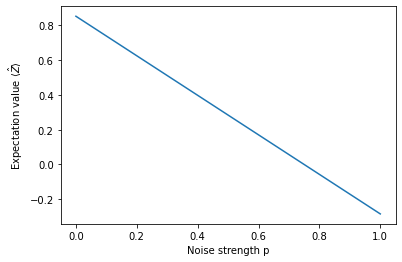

In [6]:
# Now what happens when we turn up the noise?
# In this case, our circuit has a depolarizing channel, which 
# degrades the density matrix :math:`\rho` towards the state
# ..math::
#
#   \tfrac{1}{3}\left[X\rho X + Y\rho Y + Z\rho Z\right]
#
# (at the value :math:`p=\frac{3}{4}`, it passes through the 
# maximally mixed state).
# We can see this in our circuit by looking at how the final 
# ``PauliZ`` expectation value changes as a function of the 
# noise strength 
# .
noise_vals = np.linspace(0., 1., 20)
expvals = [circuit(gate_pars, noise_param=p) for p in noise_vals]

plt.plot(noise_vals, expvals)
plt.ylabel(r"Expectation value $\langle \hat{Z} \rangle$") 
plt.xlabel("Noise strength p");

- circuit depth is limited because it introduces more noise
- Note: though we can work with noise, it should still be small enough 
  that it doesn't drown out the quantum features we are looking for

In [7]:
# Other than the ``Depolarize`` channel, our example is exactly
# the same as the 
# :doc:`qubit rotation tutorial </demos/tutorial_qubit_rotation>`_.
# Let's fix the noise parameter and see how the noise affects the
# optimization of our circuit. The goal is to tune the qubit state 
# until it has an ``PauliZ`` expectation value of :math:`-1` (the 
# lowest possible).

# declare the cost functions to be optimized
def cost(x):
    return circuit(x, noise_param=0.0)
def noisy_cost(x):
    return circuit(x, noise_param=0.3)

# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
init_params = np.array([0.011, 0.012])
noisy_circuit_params = init_params
params = init_params

for i in range(steps):
    # update the circuit parameters
    # we can optimize both in the same training loop
    params = opt.step(cost, params)
    noisy_circuit_params = opt.step(noisy_cost, noisy_circuit_params)

    if (i + 1) % 5 == 0:
        print("Step {:5d}. Cost: {: .7f}; Noisy Cost: {: .7f}"
              .format(i + 1, 
                      cost(params), 
                      noisy_cost(noisy_circuit_params)))

print("\nOptimized rotation angles (noise-free case):")
print("({: .7f}, {: .7f})".format(*params))
print("Optimized rotation angles (noisy case):")
print("({: .7f}, {: .7f})".format(*noisy_circuit_params))


Step     5. Cost:  0.9961779; Noisy Cost:  0.5993173
Step    10. Cost:  0.8974948; Noisy Cost:  0.5941737
Step    15. Cost:  0.1440492; Noisy Cost:  0.5527687
Step    20. Cost: -0.1536868; Noisy Cost:  0.3309180
Step    25. Cost: -0.9152617; Noisy Cost:  0.0470152
Step    30. Cost: -0.9994047; Noisy Cost: -0.0519407
Step    35. Cost: -0.9999964; Noisy Cost: -0.2980615
Step    40. Cost: -1.0000000; Noisy Cost: -0.5561487
Step    45. Cost: -1.0000000; Noisy Cost: -0.5969037
Step    50. Cost: -1.0000000; Noisy Cost: -0.5997996
Step    55. Cost: -1.0000000; Noisy Cost: -0.5999871
Step    60. Cost: -1.0000000; Noisy Cost: -0.5999991
Step    65. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    70. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    75. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    80. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    85. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    90. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    95. Cost: -1.0000000; Noisy Cost: -0.6

In [8]:
# There are a couple interesting observations here. 
# First, the noisy circuit isn't able to achieve the same final
# cost function value as the ideal circuit. This is because 
# the noise causes the state to be come irreversibly mixed. 
# Mixed states can't achieve the same extremal expectation values
# as pure states.
# The second observation is that both circuits still converge to 
# the same parameter values :math:`(0,\pi)`, despite having 
# different final states. 
#
# It could have been the case that noisy devices irreparably 
# damage the optimization of variational circuits, steering us 
# towards parameter values which are not useful. Luckily, at least 
# for the simple example above, this is not the case. 
# Optimizations on noisy devices can still lead to similar parameter 
# values as when we run on ideal devices. 

In [9]:
# Let's dig a bit into the underlying quantum computing theory
# to understand better what's happening.
# Expectation values of :doc:`variational circuits </glossary/variational_circuit>`_, 
# like the one we are measuring, are composed of three pieces:
# i) an initial quantum state :math:`\rho` (usually the zero state),
# ii) a parameterized unitary transformation :math:`U(\theta)`), and
# iii) measurement of a final observable :math:`\hat{B}`.
#
# The equation for the expectation value is given by the Born rule:
# ..math::
#
#   \langle \hat{B} \rangle = 
#           \mathrm{Tr}(\hat{B}U(\theta)\rho U^\dagger(\theta)).
#
# When optimizing, we can compute gradients of many common gates 
# using the :doc:`parameter-shift rule </glossary/parameter_shift>`_:
# ..math::
#
#   \frac{\partial}{\partial \theta}\langle \hat{B} \rangle(\theta)`
#      =  \frac{1}{2}
#            \left[
#                \langle \hat{B} \rangle(\theta + \frac{\pi}{2})
#              - \langle \hat{B} \rangle(\theta)
#            \right]
#
# In our example, the unitary is split into two gates, 
# ``U_1=RX`` and ``U_2=RY``, each of which takes an independent 
# parameter \theta_i. 
# What happens when we apply a 
# noisy channel :math:`\Lambda` after the gates? In this case, 
# the expectation value becomes
#
# ..math::
#
#   \langle \hat{B} \rangle = 
#           \mathrm{Tr}(\hat{B}\Lambda\left[
#                          U(\theta)\rho U^\dagger(\theta)
#                      \right]).
#
# Using the Heisenberg picture, we can transfer the channel 
# \Lambda acting on the state :math:`U(\theta)\rho U^\dagger(\theta)`
# into the _adjoint channel_ :math:`\Lambda^\dagger` acting on the 
# observable :math:`\hat{B}`, transforming it to a new observable
# :math:`\hat{B} = \Lambda^\dagger[\hat{B}]=\hat{B}'`
# With the channel present, the expectation value can be interpreted
# as if we had the same variational state, but measured a different
# observable:
#
# ..math::
#
#   \langle \hat{B} \rangle = 
#           \mathrm{Tr}(\hat{B}'(\theta)\rho U^\dagger(\theta)).
#
# This has immediate consequences for the parameter-shift rule. With
# the channel present, we have simply
#
# ..math::
#
#   \frac{\partial}{\partial \theta}\langle \hat{B} \rangle(\theta)`
#      =  \frac{1}{2}
#            \left[
#                \langle \hat{B}' \rangle(\theta + \frac{\pi}{2})
#              - \langle \hat{B}' \rangle(\theta)
#            \right].
#
# In other words, the parameter-shift rule continues to hold for all
# gates, even when we add additional channels! 
#
# ..note:: In the above, we implicitly assumed that the channel 
#          th independent of the gate's parameters.

In [10]:
# Let's confirm the above derivations with our example.


In [ ]:
##############################################################################
# References
# ----------
#
# .. [#arute2019]
#
#     Frank Arute et al. "Quantum supremacy using a programmable 
#     superconducting processor." 
#     Nature, 574(7779), 505-510.
#